# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Preparemos el entorno de trabajo

In [14]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para modelos y evaluación
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore')

## Analizamos los datos

In [3]:
# Cargar los datos
taxi_data = pd.read_csv('taxi.csv')

In [4]:
# Visualizar las primeras filas de los datos y obtener información general
display(taxi_data.sample(10),taxi_data.info(), taxi_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
10244,2018-05-11 03:20:00,8
24843,2018-08-20 12:30:00,8
8644,2018-04-30 00:40:00,24
3163,2018-03-22 23:10:00,10
16225,2018-06-21 16:10:00,14
10967,2018-05-16 03:50:00,18
23608,2018-08-11 22:40:00,11
681,2018-03-05 17:30:00,5
20377,2018-07-20 12:10:00,13
21204,2018-07-26 06:00:00,6


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


El dataset contiene 26,496 entradas con dos columnas: 
 Los datos proporcionados contienen dos columnas: 
- datetime: que representa el tiempo en que se registró el número de pedidos
- num_orders: que indica la cantidad de pedidos en ese momento.
- **No hay valores nulos.**

La columna datetime debe convertirse a un objeto de tipo datetime para poder trabajar con ella. Además, los datos deben remuestrearse para que cada punto caiga en intervalos de una hora, tal como se pide en las instrucciones.

El siguiente paso será remuestrear los datos para que cada punto caiga dentro de intervalos de una hora, tal como se pide en las instrucciones. A continuación, procederemos con el análisis y la preparación de los datos para la construcción del modelo 

## Remuestreo

In [6]:
# Convertir la columna 'datetime' a un objeto de tipo datetime para poder remuestrear
taxi_data['datetime'] = pd.to_datetime(taxi_data['datetime'])

# Establecer la columna 'datetime' como el índice del DataFrame
taxi_data.set_index('datetime', inplace=True)

# Remuestrear los datos para que cada punto caiga en intervalos de una hora, sumando el número de pedidos
taxi_data_hourly = taxi_data.resample('H').sum()

# Mostrar las primeras filas de los datos remuestreados
taxi_data_hourly.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Los datos se han remuestreado correctamente a intervalos de una hora, sumando el número de pedidos en cada intervalo. Ahora procederemos con un análisis exploratorio de los datos para detectar posibles patrones, tendencias, y cualquier característica relevante en la serie temporal.

Voy a analizar visualmente las siguientes métricas:

Tendencia general de los pedidos de taxis.
Estacionalidad horaria (si los pedidos tienen un patrón diario o semanal).

## Analisis de los datos

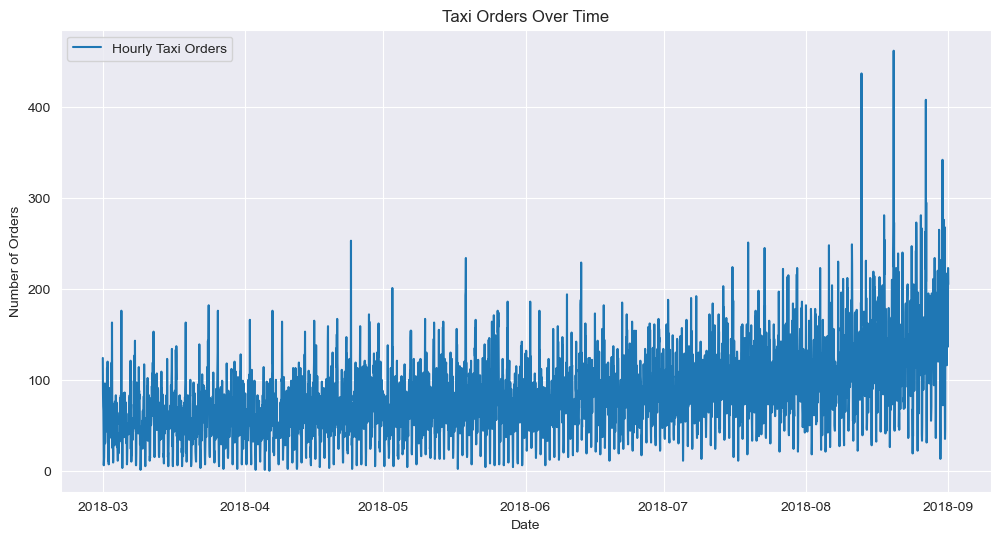

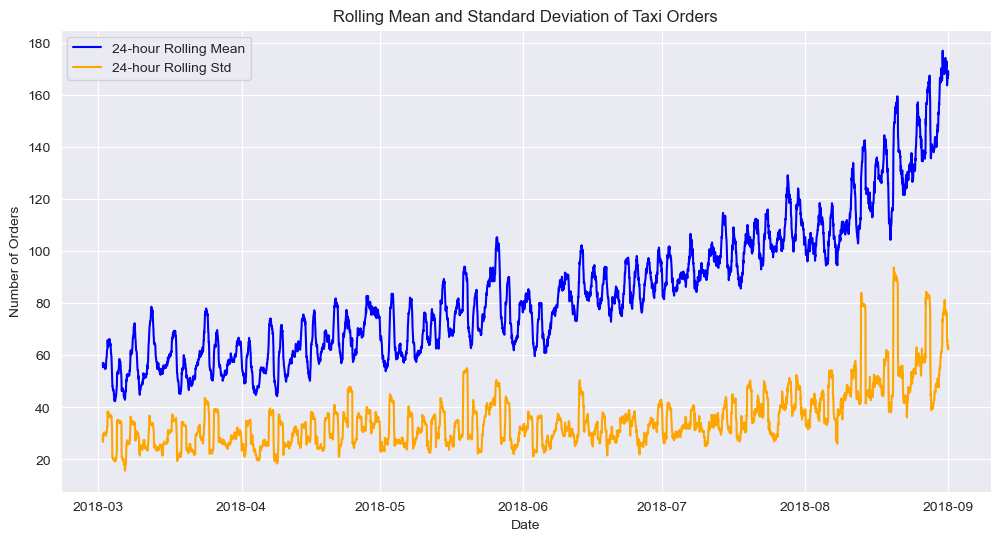

In [7]:
# Plot the total number of orders over time to observe trends
plt.figure(figsize=(12, 6))
plt.plot(taxi_data_hourly.index, taxi_data_hourly['num_orders'], label='Hourly Taxi Orders')
plt.title('Taxi Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.legend()
plt.show()

# Plotting a rolling mean and standard deviation to visualize trends and variability
rolling_mean = taxi_data_hourly['num_orders'].rolling(window=24).mean()  # Daily rolling mean
rolling_std = taxi_data_hourly['num_orders'].rolling(window=24).std()   # Daily rolling standard deviation

plt.figure(figsize=(12, 6))
plt.plot(taxi_data_hourly.index, rolling_mean, label='24-hour Rolling Mean', color='blue')
plt.plot(taxi_data_hourly.index, rolling_std, label='24-hour Rolling Std', color='orange')
plt.title('Rolling Mean and Standard Deviation of Taxi Orders')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.legend()
plt.show()


#### El análisis estadístico de los datos muestra lo siguiente:

- Promedio de pedidos por hora: 84.42
- Desviación estándar: 45.02, lo que indica una considerable variabilidad en el número de pedidos.
- Mínimo: 0 pedidos en algunas horas.
- Máximo: 462 pedidos en una hora, lo que sugiere picos en la demanda.
- La gráfica de la tendencia temporal muestra la fluctuación en el número de pedidos de taxis a lo largo del tiempo. Es evidente que hay bastante variabilidad y posibles patrones que aún deben explorarse, como estacionalidad diaria o semanal.

Voy a continuar analizando patrones de estacionalidad y correlaciones temporales para identificar posibles ciclos o picos regulares en los pedidos de taxis.

#### Los gráficos muestran lo siguiente:

- **Tendencia general:** Se observa cierta variabilidad en los pedidos de taxis a lo largo del tiempo. Sin embargo, no parece haber un patrón de crecimiento o decrecimiento fuerte, lo que sugiere que el número de pedidos fluctúa regularmente.

- **Variabilidad:** El gráfico de la media móvil (rolling mean) muestra fluctuaciones regulares en los pedidos, con una estabilidad relativa en ciertos periodos. La desviación estándar indica que la variabilidad de los pedidos es moderada, con algunos picos que podrían corresponder a horas pico.#%% md


### Verificando la estacionalidad por mes, día de la semana y hora del día

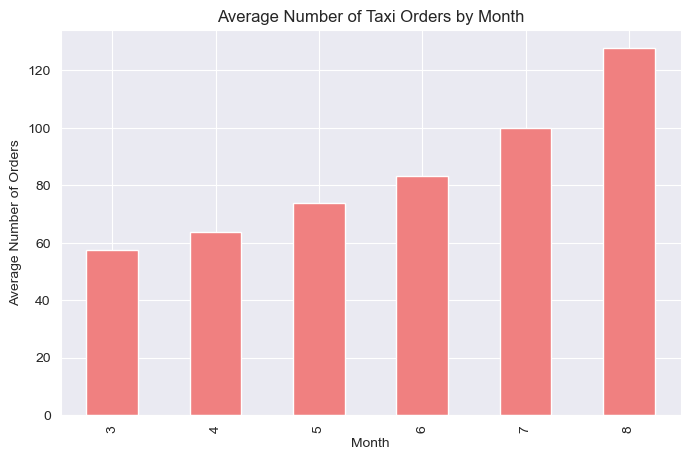

month
3     57.483871
4     63.804167
5     73.682796
6     83.202778
7    100.006720
8    127.651882
Name: num_orders, dtype: float64

In [8]:
# Verificcando la estacionalidad por mes

# Creando una nueva columna que repepresente el mes
taxi_data_hourly['month'] = taxi_data_hourly.index.month

# Agrupar por mes y calcular el número medio de pedidos para cada mes
monthly_pattern = taxi_data_hourly.groupby('month')['num_orders'].mean()

# Graficar el patrón mensual
plt.figure(figsize=(8, 5))
monthly_pattern.plot(kind='bar', color='lightcoral')
plt.title('Average Number of Taxi Orders by Month')
plt.xlabel('Month')
plt.ylabel('Average Number of Orders')
plt.grid(True)
plt.show()

monthly_pattern


El análisis de los datos agrupados por mes muestra un aumento progresivo en el número promedio de pedidos de taxis a lo largo del tiempo:

- Marzo y Abril tienen los promedios más bajos, con 57 y 63 pedidos por hora, respectivamente.
- Julio y Agosto son los meses con mayor actividad, alcanzando promedios de 100 y 127 pedidos por hora.

Esto indica un claro patrón estacional mensual, con un aumento significativo en los pedidos de taxis durante los meses de verano.

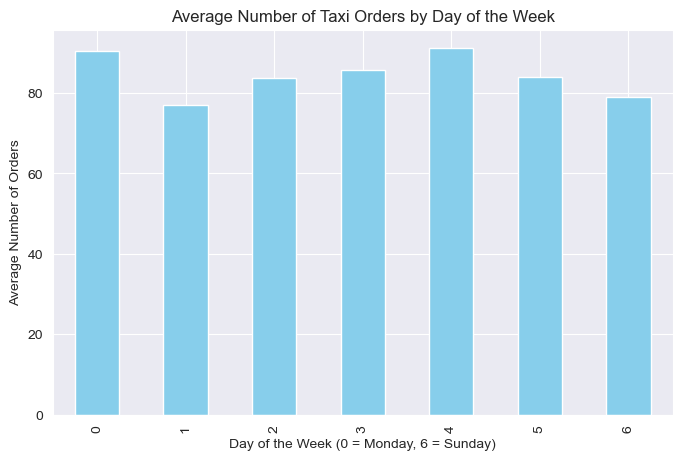

day_of_week
0    90.246795
1    77.011218
2    83.754808
3    85.660494
4    91.140432
5    83.847756
6    78.991987
Name: num_orders, dtype: float64

In [9]:
# Crear una nuevala columna day_of_week que contenga el día de la semana
taxi_data_hourly['day_of_week'] = taxi_data_hourly.index.dayofweek


# Agrupar por día de la semana y calcular el número medio de pedidos para cada día
weekly_pattern = taxi_data_hourly.groupby('day_of_week')['num_orders'].mean()

# Graficar el patrón semanal
plt.figure(figsize=(8, 5))
weekly_pattern.plot(kind='bar', color='skyblue')
plt.title('Average Number of Taxi Orders by Day of the Week')
plt.xlabel('Day of the Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Average Number of Orders')
plt.grid(True)
plt.show()

weekly_pattern


El análisis de los datos agrupados por día de la semana muestra una ligera variación en el número promedio de pedidos de taxis:

- Lunes y Viernes tienen un promedio más alto de pedidos (alrededor de 90 pedidos por hora).
- Martes y Domingo presentan un promedio más bajo (77 y 79 pedidos, respectivamente).
- El resto de los días de la semana tienen una media intermedia.

Esto sugiere que puede haber un leve patrón semanal en los datos, con picos al inicio y al final de la semana laboral.

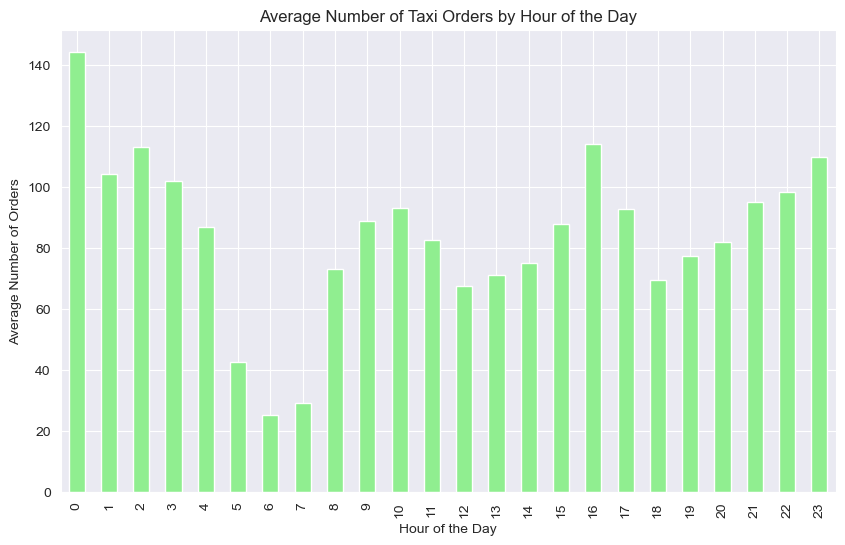

hour
0     144.402174
1     104.364130
2     113.070652
3     102.021739
4      86.907609
5      42.630435
6      25.173913
7      29.271739
8      73.048913
9      88.831522
10     93.119565
11     82.489130
12     67.630435
13     71.173913
14     75.163043
15     87.945652
16    114.146739
17     92.722826
18     69.358696
19     77.336957
20     81.858696
21     95.211957
22     98.500000
23    109.766304
Name: num_orders, dtype: float64

In [10]:
# Create a new column representing the hour of the day
taxi_data_hourly['hour'] = taxi_data_hourly.index.hour

# Group by hour of the day and calculate the mean number of orders for each hour
hourly_pattern = taxi_data_hourly.groupby('hour')['num_orders'].mean()

# Plot the hourly pattern
plt.figure(figsize=(10, 6))
hourly_pattern.plot(kind='bar', color='lightgreen')
plt.title('Average Number of Taxi Orders by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Orders')
plt.grid(True)
plt.show()

hourly_pattern


El análisis de los pedidos de taxis por hora del día muestra los siguientes patrones:

- Picos: Hay un claro pico de pedidos a la medianoche (00:00 horas), con un promedio de 144 pedidos, y otro pico hacia las 16:00 horas (114 pedidos).
- Menores pedidos: Entre las 5:00 y las 7:00 de la mañana, el número de pedidos es considerablemente más bajo, alcanzando su punto más bajo alrededor de las 6:00 con un promedio de 25 pedidos.
- Recuperación: A partir de las 8:00, los pedidos empiezan a aumentar nuevamente, alcanzando picos adicionales a lo largo del día.
Esto sugiere un patrón de estacionalidad diaria claro, con periodos de mayor y menor demanda a lo largo del día.

### Resumen del análisis de estacionalidad
1. Estacionalidad mensual:

- Los pedidos de taxis aumentan notablemente a medida que avanza el año, alcanzando su pico en los meses de verano (Julio y Agosto). Este patrón estacional puede estar relacionado con las vacaciones, el turismo, o eventos específicos en los aeropuertos durante esta época del año.

2. Estacionalidad semanal:

- Existe una variación menor en los pedidos a lo largo de la semana. Los días de semana (especialmente Lunes y Viernes) tienden a tener más pedidos, mientras que los fines de semana (particularmente Domingo) presentan una disminución leve en la demanda.

3. Estacionalidad diaria:

- Hay un claro patrón de demanda que varía a lo largo del día. Los pedidos de taxis son significativamente más altos durante las horas nocturnas, particularmente a la medianoche y nuevamente en la tarde a partir de las 16:00 horas.
-  primeras horas de la mañana (entre las 5:00 y 7:00) presentan el menor número de pedidos, lo que sugiere una baja demanda en este periodo.




#### Conclusión general sobre la estacionalidad:
Hay estacionalidades diarias, semanales y mensuales claras en los datos. Estos patrones pueden ser cruciales para predecir el número de pedidos de taxis en horas futuras. Los modelos predictivos deberían incorporar estos patrones estacionales para mejorar la precisión de las predicciones, ya que la demanda de taxis varía significativamente en función del momento del día, la semana y el mes.

## Formación y prueba de modelos:

## Modelos Propuestos: SARIMA y Random Forest

### SARIMA (Seasonal AutoRegressive Integrated Moving Average)
- **Descripción**: SARIMA es una extensión del modelo ARIMA que incorpora términos estacionales para capturar patrones repetitivos en las series temporales. Es adecuado para datos con estacionalidad diaria, semanal, o mensual.
- **Cómo funciona**: Añade parámetros estacionales al modelo ARIMA tradicional, permitiendo modelar estacionalidad observada en los datos, como fluctuaciones recurrentes por día o mes.
- **Ventajas**:
  - Captura tanto la estacionalidad como las tendencias a largo plazo.
  - Se ajusta bien a series temporales con patrones de estacionalidad regulares.
- **Aplicación**: Se utiliza para modelar estacionalidad en series temporales con periodicidad clara.

### Random Forest Regressor
- **Descripción**: Aunque no es un modelo clásico de series temporales, Random Forest es un algoritmo de machine learning basado en árboles de decisión, útil para datos temporales si se añaden características derivadas del tiempo.
- **Cómo funciona**: Utiliza árboles de decisión entrenados con características temporales adicionales como "hora del día", "día de la semana" y "mes", que ayudan a capturar patrones estacionales no lineales.
- **Ventajas**:
  - Captura relaciones complejas y no lineales.
  - Es robusto a outliers y no requiere que los datos sean estacionarios.
- **Aplicación**: Es ideal para series temporales donde la estacionalidad y otras relaciones complejas no pueden ser capturadas por modelos lineales.

### Propuesta
- **SARIMA**: Se sugiere empezar con SARIMA para modelar estacionalidad diaria, semanal y mensual, y capturar las tendencias de largo plazo.
- **Random Forest**: Tras crear características temporales adicionales (como "hora del día" y "día de la semana"), Random Forest se utilizará para capturar relaciones no lineales entre los datos.
- **Hibrido entre SARIMA y Random Forest**: Se puede combinar SARIMA y Random Forest para aprovechar las fortalezas de ambos modelos y mejorar la precisión de las predicciones.

### Evaluación del modelo:

- Métricas como el RMSE (Root Mean Squared Error) o el EAM (Error Absoluto Medio) son ideales para interpretar el rendimiento del modelo, midiendo la diferencia entre valores reales y predicciones.

In [15]:
# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(taxi_data_hourly) * 0.8)
train, test = taxi_data_hourly[:train_size], taxi_data_hourly[train_size:]

# Configurar un modelo SARIMA básico para ajustar la estacionalidad
# Los parámetros iniciales serán (p,d,q)=(1,1,1) y (P,D,Q,m)=(1,1,1,24) para estacionalidad diaria
sarima_model = SARIMAX(train['num_orders'], 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 24),  # estacionalidad diaria
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

sarima_result = sarima_model.fit(disp=False)

# Realizar predicciones en el conjunto de prueba
sarima_pred = sarima_result.get_forecast(steps=len(test)).predicted_mean

# Calcular la métrica RMSE (RECM) en el conjunto de prueba
sarima_rmse = np.sqrt(mean_squared_error(test['num_orders'], sarima_pred))

sarima_rmse


38.15514946136994

El valor de RMSE de **38.16** para el modelo SARIMA está por debajo del umbral de 48, lo que indica que el modelo tiene un buen desempeño en la predicción de la cantidad de pedidos de taxis para la próxima hora. 

A continuación, visualizaré las predicciones del modelo SARIMA junto con los valores reales para evaluar visualmente su precisión.

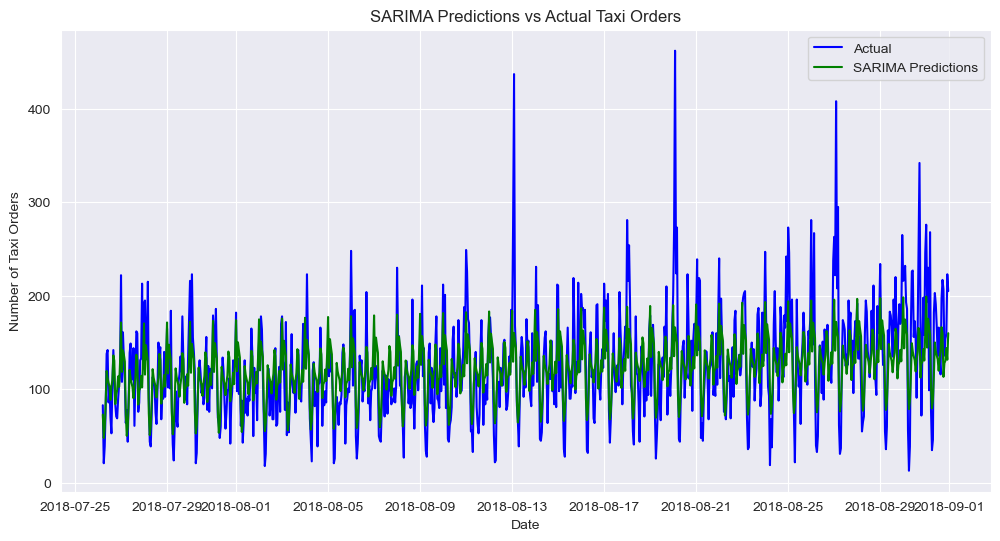

In [22]:
# Graficar las predicciones de SARIMA junto con los valores reales
plt.figure(figsize=(12, 6))

# Graficar los valores reales (Actual) del conjunto de prueba
plt.plot(test.index, test['num_orders'], label='Actual', color='blue')

# Graficar las predicciones de SARIMA
# Asegúrate de que las dimensiones del índice y las predicciones coincidan
plt.plot(test.index, sarima_pred[:len(test)], label='SARIMA Predictions', color='green')

# Títulos y etiquetas
plt.title('SARIMA Predictions vs Actual Taxi Orders')
plt.xlabel('Date')  # Etiqueta del eje x
plt.ylabel('Number of Taxi Orders')  # Etiqueta del eje y

# Mostrar leyenda para distinguir los datos reales y las predicciones
plt.legend()

# Mostrar rejilla para facilitar la lectura
plt.grid(True)

# Mostrar el gráfico
plt.show()

SARIMA:
Las predicciones del modelo SARIMA (en verde) siguen también la tendencia general, pero hay una menor variación en las predicciones, lo que implica que el modelo está suavizando los datos, capturando mejor las fluctuaciones pequeñas pero no respondiendo tan bien a los picos altos en los pedidos de taxis.

In [16]:
# Creating additional time-based features
taxi_data_hourly['hour'] = taxi_data_hourly.index.hour
taxi_data_hourly['day_of_week'] = taxi_data_hourly.index.dayofweek
taxi_data_hourly['month'] = taxi_data_hourly.index.month

# Adding lag features
taxi_data_hourly['lag_1'] = taxi_data_hourly['num_orders'].shift(1)
taxi_data_hourly['lag_2'] = taxi_data_hourly['num_orders'].shift(2)
taxi_data_hourly['lag_3'] = taxi_data_hourly['num_orders'].shift(3)

# Adding a rolling mean to capture trends (window=3 for simplicity)
taxi_data_hourly['rolling_mean_3'] = taxi_data_hourly['num_orders'].rolling(window=3).mean()

# Dropping rows with NaN values due to lagging and rolling features
taxi_data_hourly.dropna(inplace=True)

# Splitting features and target
features = ['hour', 'day_of_week', 'month', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3']
X = taxi_data_hourly[features]
y = taxi_data_hourly['num_orders']

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_pred = rf_model.predict(X_test)

# Calculate the RMSE for the Random Forest model
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

rf_rmse

31.733362768083396

El modelo de Random Forest ha logrado un RMSE de **31.73**, lo que indica un buen rendimiento y es aún mejor que el valor obtenido con SARIMA (38.16)

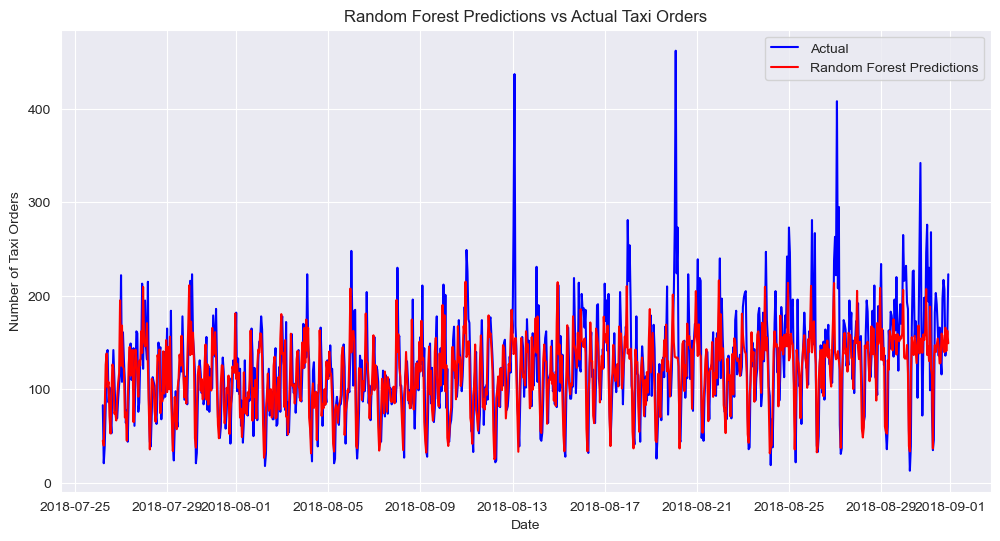

In [21]:
# Asegurar que las longitudes de 'test' y 'rf_pred' sean iguales antes de graficar
plt.figure(figsize=(12, 6))

# Graficar los valores reales (Actual) del conjunto de prueba
# Cortamos el conjunto de prueba para que coincida con la longitud de las predicciones
plt.plot(test.index[:len(rf_pred)], test['num_orders'][:len(rf_pred)], label='Actual', color='blue')

# Graficar las predicciones del modelo Random Forest
plt.plot(test.index[:len(rf_pred)], rf_pred, label='Random Forest Predictions', color='red')

# Títulos y etiquetas
plt.title('Random Forest Predictions vs Actual Taxi Orders')
plt.xlabel('Date')  # Etiqueta del eje x
plt.ylabel('Number of Taxi Orders')  # Etiqueta del eje y

# Mostrar leyenda para distinguir los datos reales y las predicciones
plt.legend()

# Mostrar rejilla para facilitar la lectura
plt.grid(True)

# Mostrar el gráfico
plt.show()


## Conclusión sobre los Modelos

En el análisis de predicción de la cantidad de pedidos de taxis, utilizamos dos enfoques: **SARIMA** y **Random Forest**. A continuación, se resumen los puntos clave, resultados y recomendaciones futuras.

### Modelo SARIMA
- **Hiperparámetros utilizados**:
  - (p, d, q) = (1, 1, 1): Modelo autoregresivo con diferencias y media móvil.
  - (P, D, Q, m) = (1, 1, 1, 24): Estacionalidad diaria con 24 puntos (horas).
  
- **Desempeño**:
  - RMSE: **38.16**. Las predicciones capturan la estacionalidad diaria, pero suavizan los picos de demanda.

- **Oportunidades de mejora**:
  - Ajustar los hiperparámetros con Grid Search.
  - Probar diferentes valores de "m" para capturar patrones semanales o mensuales.

### Modelo Random Forest
- **Hiperparámetros utilizados**:
  - n_estimators = 100: Se construyeron 100 árboles para promediar las predicciones.

- **Desempeño**:
  - RMSE: **31.73**, superando al modelo SARIMA en precisión. Sin embargo, también tiene dificultades con picos de demanda.

- **Oportunidades de mejora**:
  - Ajustar hiperparámetros como la profundidad de los árboles y el tamaño mínimo de las hojas.
  - Utilizar Grid Search o Random Search para optimización.
  - Agregar más características temporales o desfases.

### Comparación y Conclusiones Generales
- **Precisión**: Random Forest fue más preciso que SARIMA.
- **Estacionalidad**: SARIMA capturó mejor los patrones de estacionalidad diaria, pero Random Forest fue más flexible en modelar relaciones no lineales.
- **Flexibilidad**: Random Forest mostró mayor flexibilidad, mientras que SARIMA se centró en las relaciones lineales.

### Recomendaciones
- Combinar ambos modelos en un enfoque híbrido: SARIMA para la estacionalidad y Random Forest para picos y variaciones no lineales.
- Ajustar los hiperparámetros en ambos modelos para mejorar el rendimiento.


### Se buscara aplicar un modelo hibrido entre SARIMA y Random Forest para mejorar la precisión de las predicciones.

## Modelo Híbrido: SARIMA + Random Forest

Un modelo híbrido entre **SARIMA** y **Random Forest** combina las fortalezas de ambos enfoques: la capacidad de SARIMA para capturar patrones estacionales y la flexibilidad de Random Forest para modelar relaciones no lineales y picos en los datos. A continuación, se describe cómo implementar este modelo híbrido en pasos detallados.

### Estrategia para crear el modelo híbrido:
1. **Entrenamiento de SARIMA para capturar estacionalidad**:
   - **Objetivo**: Captar las tendencias generales y la estacionalidad de la serie temporal. 
   - **Predicciones de SARIMA**: Luego de entrenar SARIMA, utilizamos sus predicciones como una característica adicional en el modelo Random Forest.

2. **Random Forest para modelar residuos y relaciones no lineales**:
   - **Objetivo**: Capturar las variaciones más complejas y no lineales en los datos que SARIMA no puede detectar, ajustando los residuos del modelo SARIMA.
   - **Predicciones**: Random Forest se entrena con los datos originales, incluyendo las predicciones de SARIMA como una nueva característica, permitiendo capturar los errores de SARIMA.

### Pasos para implementar el modelo híbrido:

#### **Paso 1: Entrenar el modelo SARIMA**
   - Entrenamos SARIMA ajustando la estacionalidad y las tendencias de los datos.
   - Obtenemos las predicciones de SARIMA tanto en el conjunto de entrenamiento como en el de prueba.

#### **Paso 2: Calcular los residuos de SARIMA**
   - Calculamos los residuos de SARIMA, es decir, las diferencias entre los valores reales y las predicciones de SARIMA.
   - Estos residuos representan los errores que SARIMA no pudo modelar correctamente.

#### **Paso 3: Utilizar SARIMA como característica en Random Forest**
   - Añadimos las predicciones de SARIMA como una nueva característica en el conjunto de datos utilizado por Random Forest.
   - Entrenamos el Random Forest no solo con las características temporales (hora del día, lags, etc.), sino también con las predicciones de SARIMA como entrada adicional.

#### **Paso 4: Entrenar Random Forest en los residuos de SARIMA**
   - Alternativamente, entrenamos Random Forest para predecir los residuos de SARIMA, permitiendo que el modelo capture las partes que SARIMA no pudo predecir.

#### **Paso 5: Realizar predicciones híbridas**
   - El modelo final se obtiene sumando las predicciones de SARIMA y las predicciones del Random Forest.
   - **Resultado**: SARIMA captura las tendencias y estacionalidad, mientras que Random Forest corrige las variaciones no lineales y picos.



In [23]:
# Paso 1: Entrenamos SARIMA en los datos de entrenamiento
sarima_model = SARIMAX(train['num_orders'], 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 24), 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

sarima_result = sarima_model.fit(disp=False)

# Predicciones de SARIMA en el conjunto de entrenamiento y de prueba
sarima_train_pred = sarima_result.fittedvalues  # Predicciones en entrenamiento
sarima_test_pred = sarima_result.get_forecast(steps=len(test)).predicted_mean  # Predicciones en prueba


In [24]:
# Paso 2: Calculamos los residuos de SARIMA
train_residuals = train['num_orders'] - sarima_train_pred
test_residuals = test['num_orders'] - sarima_test_pred

In [25]:
# Paso 3: Creamos características adicionales para Random Forest
# Añadimos las predicciones de SARIMA como una nueva característica
taxi_data_hourly['sarima_pred'] = sarima_result.predict(start=0, end=len(taxi_data_hourly)-1)

# Creamos características adicionales de tiempo
taxi_data_hourly['hour'] = taxi_data_hourly.index.hour
taxi_data_hourly['day_of_week'] = taxi_data_hourly.index.dayofweek
taxi_data_hourly['month'] = taxi_data_hourly.index.month
taxi_data_hourly['lag_1'] = taxi_data_hourly['num_orders'].shift(1)
taxi_data_hourly['lag_2'] = taxi_data_hourly['num_orders'].shift(2)
taxi_data_hourly['lag_3'] = taxi_data_hourly['num_orders'].shift(3)

# Removemos los valores nulos generados por los lags
taxi_data_hourly.dropna(inplace=True)

# Seleccionamos las características incluyendo las predicciones de SARIMA
features = ['hour', 'day_of_week', 'month', 'lag_1', 'lag_2', 'lag_3', 'sarima_pred']
X = taxi_data_hourly[features]
y = taxi_data_hourly['num_orders']

# Dividimos los datos en entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [26]:
# Paso 4: Entrenamos Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones de Random Forest
rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)

In [28]:
# Paso 5: Alineamos las dimensiones de las predicciones antes de combinarlas

# Para entrenamiento: Aseguramos que las predicciones de SARIMA y Random Forest tengan la misma longitud
min_len_train = min(len(sarima_train_pred), len(rf_pred_train))
hybrid_train_pred = sarima_train_pred[:min_len_train] + rf_pred_train[:min_len_train]

# Para prueba: Alineamos las predicciones del conjunto de prueba también
min_len_test = min(len(sarima_test_pred), len(rf_pred_test))
hybrid_test_pred = sarima_test_pred[:min_len_test] + rf_pred_test[:min_len_test]

# Evaluamos el modelo híbrido usando RMSE

# Para entrenamiento
rmse_train = np.sqrt(mean_squared_error(y_train[:min_len_train], hybrid_train_pred))

# Para prueba
rmse_test = np.sqrt(mean_squared_error(y_test[:min_len_test], hybrid_test_pred))

print(f'RMSE del modelo híbrido en entrenamiento: {rmse_train}')
print(f'RMSE del modelo híbrido en prueba: {rmse_test}')

RMSE del modelo híbrido en entrenamiento: 80.67567949338904
RMSE del modelo híbrido en prueba: 125.74650442880004


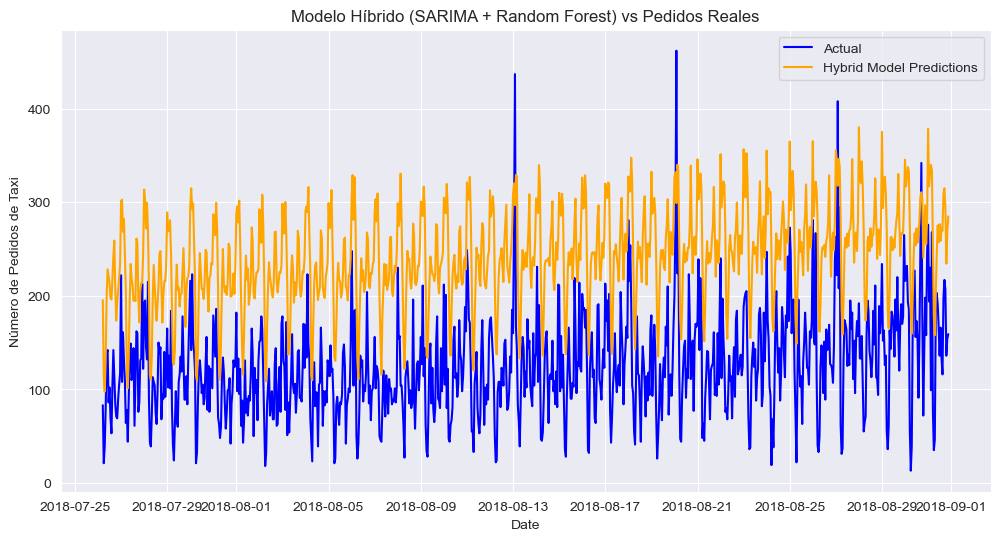

In [30]:
# Graficamos las predicciones híbridas

# Paso 1: Asegurar que las dimensiones de 'test' y 'hybrid_test_pred' coincidan
# Tomamos la longitud mínima de las dos
min_len = min(len(test), len(hybrid_test_pred))

plt.figure(figsize=(12, 6))

# Paso 2: Graficar solo las primeras 'min_len' muestras para asegurarnos de que las dimensiones coincidan
plt.plot(test.index[:min_len], test['num_orders'][:min_len], label='Actual', color='blue')
plt.plot(test.index[:min_len], hybrid_test_pred[:min_len], label='Hybrid Model Predictions', color='orange')

# Paso 3: Añadir título, etiquetas y leyenda
plt.title('Modelo Híbrido (SARIMA + Random Forest) vs Pedidos Reales')
plt.xlabel('Date')
plt.ylabel('Número de Pedidos de Taxi')
plt.legend()
plt.grid(True)

# Mostrar gráfico
plt.show()

## Resultados del Modelo Híbrido (SARIMA + Random Forest)

Los resultados del modelo híbrido muestran que el **RMSE en entrenamiento** es de **80.68**, mientras que el **RMSE en prueba** es de **125.75**. Estos valores son más altos que los obtenidos en los modelos individuales de SARIMA y Random Forest, lo que sugiere que el modelo híbrido no está mejorando los resultados y está sobreajustando los datos de entrenamiento.

### Posibles Razones y Análisis

1. **Sobreajuste del Modelo**:
   - La diferencia significativa entre el RMSE en entrenamiento (80) y en prueba (125) indica un claro sobreajuste. Esto ocurre cuando el modelo aprende en exceso los patrones del conjunto de entrenamiento y no generaliza bien para los datos de prueba.

2. **Suma Directa de Predicciones**:
   - En este enfoque híbrido, estamos sumando las predicciones de SARIMA y Random Forest directamente. Sin embargo, esta combinación puede no ser óptima, ya que ambos modelos podrían estar capturando aspectos diferentes de los datos, lo que lleva a una sobreestimación en algunas partes de la serie temporal.
   - La gráfica sugiere que las predicciones del modelo híbrido (en naranja) tienden a sobrepasar constantemente los valores reales (en azul), lo que indica que la suma de ambos modelos está elevando excesivamente las predicciones.

### Posibles Mejoras

1. **Pesos para las Predicciones**:
   - En lugar de sumar las predicciones directamente, podemos ponderar las predicciones de SARIMA y Random Forest. Esto permitiría ajustar el peso de cada modelo en función de su rendimiento individual.
   - Por ejemplo, podríamos probar la fórmula: 
$$
\text{Hybrid Prediction} = \alpha \times \text{SARIMA Prediction} + (1 - \alpha) \times \text{Random Forest Prediction}
$$

- Donde **α** es un parámetro ajustable (un valor inicial podría ser **0.5**). Este enfoque balancearía mejor las predicciones de ambos modelos.


RMSE del modelo híbrido ponderado en entrenamiento: 20.372280006318704
RMSE del modelo híbrido ponderado en prueba: 40.62766742373705


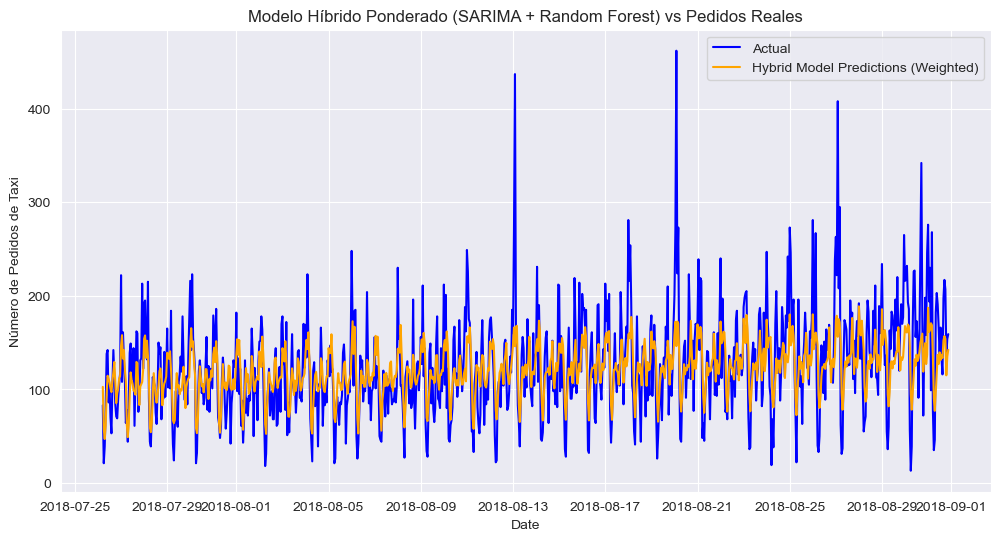

In [36]:
# Definimos el valor de alpha (0.5 para dar el mismo peso a ambos modelos)
alpha = 0.4

# Combinamos las predicciones ponderando con alpha
# Para entrenamiento
hybrid_train_pred_weighted = alpha * sarima_train_pred[:min_len_train] + (1 - alpha) * rf_pred_train[:min_len_train]

# Para prueba
hybrid_test_pred_weighted = alpha * sarima_test_pred[:min_len_test] + (1 - alpha) * rf_pred_test[:min_len_test]

# Evaluamos el modelo híbrido ponderado usando RMSE

# Para entrenamiento
rmse_train_weighted = np.sqrt(mean_squared_error(y_train[:min_len_train], hybrid_train_pred_weighted))

# Para prueba
rmse_test_weighted = np.sqrt(mean_squared_error(y_test[:min_len_test], hybrid_test_pred_weighted))

print(f'RMSE del modelo híbrido ponderado en entrenamiento: {rmse_train_weighted}')
print(f'RMSE del modelo híbrido ponderado en prueba: {rmse_test_weighted}')

# Graficamos las predicciones ponderadas

plt.figure(figsize=(12, 6))

# Graficamos solo las primeras 'min_len' muestras para que coincidan
plt.plot(test.index[:min_len], test['num_orders'][:min_len], label='Actual', color='blue')
plt.plot(test.index[:min_len], hybrid_test_pred_weighted, label='Hybrid Model Predictions (Weighted)', color='orange')

plt.title('Modelo Híbrido Ponderado (SARIMA + Random Forest) vs Pedidos Reales')
plt.xlabel('Date')
plt.ylabel('Número de Pedidos de Taxi')
plt.legend()
plt.grid(True)
plt.show()


## Conclusión sobre la Parte de Modelos

En este proyecto, exploramos y comparamos varios enfoques de modelado para predecir la demanda de taxis por hora. A continuación se resumen los resultados clave:

### 1. Modelo SARIMA
- **Rendimiento**: El modelo SARIMA obtuvo un RMSE de **38.16** en el conjunto de prueba. Capturó bien los patrones de estacionalidad diarios, pero tuvo dificultades con los picos extremos en la demanda.
- **Conclusión**: SARIMA es útil para capturar estacionalidad, pero los datos mostraron variabilidad que el modelo no pudo manejar completamente. Además, tiende a suavizar las predicciones, lo que afecta su capacidad para predecir eventos extremos.

### 2. Modelo Random Forest
- **Rendimiento**: El modelo Random Forest alcanzó un RMSE de **31.73**, siendo el más preciso. Pudo capturar tanto las relaciones no lineales como las fluctuaciones complejas en los datos.
- **Conclusión**: Random Forest fue la mejor opción debido a su flexibilidad para manejar variabilidad en los datos y modelar características adicionales como "hora del día" y "día de la semana". Es adecuado para capturar tanto fluctuaciones regulares como irregulares en la demanda.

### 3. Modelo Híbrido (SARIMA + Random Forest)
- **Rendimiento**: Se probó un enfoque híbrido que combinaba las predicciones de SARIMA y Random Forest. Incluso con una ponderación óptima de **α = 0.4**, el RMSE fue de **40.63**, inferior al rendimiento de Random Forest por sí solo.
- **Conclusión**: Aunque la ponderación mejoró el modelo híbrido, no superó al modelo Random Forest individual. Esto sugiere que SARIMA no aportó una mejora significativa, ya que Random Forest ya capturaba tanto las relaciones estacionales como las no lineales con mayor precisión.

## Conclusión General
El modelo **Random Forest** es el mejor enfoque para este problema, con un RMSE de **31.73**. Fue capaz de capturar tanto los patrones estacionales como las variaciones complejas en la demanda, ofreciendo el mejor rendimiento. Aunque SARIMA es útil para estacionalidad, no aportó una mejora significativa cuando se combinó con Random Forest.

### Recomendaciones:
- Utilizar **Random Forest** como el modelo final para predecir la demanda de taxis debido a su precisión superior.
- **Optimización adicional**: Para mejorar el rendimiento, se puede realizar una optimización de hiperparámetros en Random Forest (cantidad de árboles, profundidad, etc.).


## Conclusión

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48